# Scater: quality control and filtering

In [1]:
suppressPackageStartupMessages({
    library(Matrix)
    library(scater)
    library(cowplot)
})

## Loading the matrix

In [2]:
dir.create("1.3.scater")

In [3]:
setwd("1.3.scater/")

In [4]:
matrix <- readRDS(file = "/mnt/c/Users/u0124158/Documents/NGS/DebnathPSC/geneCounts/matrix.Rds")
matrix[1:5, 1:5]

,AACACGCATCTG_plate_47_quad1,AACGGAATGGCT_plate_47_quad1,AACGTGCGTATG_plate_47_quad1,AAGCACGCTATG_plate_47_quad1,AAGCCTTGGTTC_plate_47_quad1
0610009B22Rik,0,13,0,31,0
0610009E02Rik,0,0,0,0,0
0610009L18Rik,0,0,0,0,0
0610010F05Rik,0,0,0,26,0
0610010K14Rik,0,0,0,0,0


In [26]:
matrix = as.matrix(matrix)
dim(matrix)

[1] 26288   691

## Barcode and feature files

### Barcode file

In [5]:
barcodes <- colnames(matrix)
barcodes <- as.data.frame(barcodes)

write.table(barcodes, file = "barcodes.tsv", quote = FALSE, row.names = FALSE)

### Feature file

In [8]:
features <- rownames(matrix)

write.table(features, file = "features.tsv", quote = FALSE, row.names = FALSE)

## The `SingleCellExperiment` object

In [10]:
matrix_dir = "./"

In [11]:
barcode.path <- paste0(matrix_dir, "barcodes.tsv")
features.path <- paste0(matrix_dir, "features.tsv")
metadata.path <- paste0(matrix_dir, "metadata.tsv")

In [12]:
feature.names = read.delim(features.path, header = FALSE, stringsAsFactors = FALSE)
barcode.names = read.delim(barcode.path, header = FALSE, stringsAsFactors = FALSE)
metadata = read.delim(metadata.path, header = FALSE, stringsAsFactors = FALSE)

In [14]:
colnames(feature.names) <- c("GeneID")

In [17]:
colnames(metadata) <- c("Cells", "Origin", "Organism")

# sort the metadata to match the order of the columns
metadata <- metadata[order(match(metadata[,1], barcode.names[,1])),]

### Generate the object

In [27]:
sceMP <- SingleCellExperiment(assays = list(counts = matrix),
                              colData = metadata,
                              rowData = feature.names)
sceMP

class: SingleCellExperiment 
dim: 26288 691 
metadata(0):
assays(1): counts
rownames(26288): 0610009B22Rik 0610009E02Rik ... Zp4-ps n-TStga1
rowData names(1): GeneID
colnames(691): AACACGCATCTG_plate_47_quad1 AACGGAATGGCT_plate_47_quad1
  ... TTCGACCAACGA_plate_48_quad4 TTGTCGCATCCA_plate_48_quad4
colData names(3): Cells Origin Organism
reducedDimNames(0):
spikeNames(0):

In [28]:
colData(sceMP)

DataFrame with 691 rows and 3 columns
                                                  Cells      Origin    Organism
                                            <character> <character> <character>
AACACGCATCTG_plate_47_quad1 AACACGCATCTG_plate_47_quad1  Periosteum       Mouse
AACGGAATGGCT_plate_47_quad1 AACGGAATGGCT_plate_47_quad1  Periosteum       Mouse
AACGTGCGTATG_plate_47_quad1 AACGTGCGTATG_plate_47_quad1  Periosteum       Mouse
AAGCACGCTATG_plate_47_quad1 AAGCACGCTATG_plate_47_quad1  Periosteum       Mouse
AAGCCTTGGTTC_plate_47_quad1 AAGCCTTGGTTC_plate_47_quad1  Periosteum       Mouse
...                                                 ...         ...         ...
TTACGCGCATTG_plate_48_quad4 TTACGCGCATTG_plate_48_quad4  Periosteum       Mouse
TTAGCCACTCTG_plate_48_quad4 TTAGCCACTCTG_plate_48_quad4  Periosteum       Mouse
TTCCAGAGACTG_plate_48_quad4 TTCCAGAGACTG_plate_48_quad4  Periosteum       Mouse
TTCGACCAACGA_plate_48_quad4 TTCGACCAACGA_plate_48_quad4  Periosteum       Mouse
TT

In [29]:
rowData(sceMP)

DataFrame with 26288 rows and 1 column
                     GeneID
                <character>
0610009B22Rik 0610009B22Rik
0610009E02Rik 0610009E02Rik
0610009L18Rik 0610009L18Rik
0610010F05Rik 0610010F05Rik
0610010K14Rik 0610010K14Rik
...                     ...
Xirp1                 Xirp1
Xkr4                   Xkr4
Zfp520-ps         Zfp520-ps
Zp4-ps               Zp4-ps
n-TStga1           n-TStga1

Dimensions of the raw data are **26.288 genes and 691 cells**.

## Calculating QC metrics

First we identify rows corresponding to mitochondrial genes, which can be found based on the rownames.

In [33]:
is.mito <- grepl("^mt-", rownames(sceMP))
mito.list <- grep("^mt-", rownames(sceMP), value = TRUE)

For each cell we calculate quality control metrics such as the total number of counts or the proportion of counts in mitochondrial genes.

In [38]:
sceMP <- calculateQCMetrics(sceMP, feature_controls = list(Mt = is.mito))
head(colnames(colData(sceMP)),7)

[1] "Cells"                          "Origin"                        
[3] "Organism"                       "is_cell_control"               
[5] "total_features_by_counts"       "log10_total_features_by_counts"
[7] "total_counts"

In [39]:
head(colnames(rowData(sceMP)))

[1] "GeneID"                "is_feature_control"    "is_feature_control_Mt"
[4] "mean_counts"           "log10_mean_counts"     "n_cells_by_counts"

### Quality control of the cells

Low-quality cells need to be removed to ensure that technical effects do not distort downstream analysis
results. Two common measures of cell quality are the library size and the number of expressed features in
each library. The library size is defined as the total sum of counts across all features, i.e. genes. Cells with
relatively small library sizes are considered to be of low quality as the RNA has not been efficiently captured
(i.e. converted into cDNA and amplified) during library preparation. The number of expressed features in
each cell is defined as the number of features with non-zero counts for that cell. Any cell with very few
expressed genes is likely to be of poor quality as the diverse transcript population has not been successfully
captured. The distribution of both of these metrics can be seen in the histograms below.

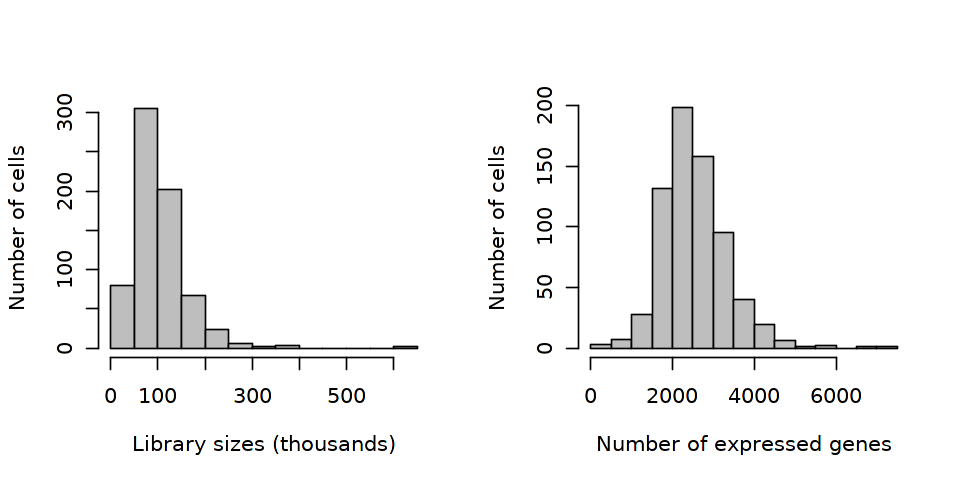

In [73]:
par(mfrow = c(1,2))
hist(sceMP$total_counts/1e3, xlab = "Library sizes (thousands)", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")
hist(sceMP$total_features_by_counts, xlab = "Number of expressed genes", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

options(repr.plot.width = 8, repr.plot.height = 4)

Selecting a threshold for these metrics is not straightforward as their absolute values depend on the protocol
and the biological system. For example, sequencing to greater depth will lead to more reads, regardless of
the quality of the cells. To obtain an adaptive threshold, we assume that most of the dataset consists of
high-quality cells. We remove cells with log-library sizes that deviate more than 3 absolute deviations from
the median (Lun et al. 2016, Davie et al., 2018). The log transformation is performed to improve resolution
at small values, which is especially necessary when the absolute deviation of the raw values is comparable to
or greater than the median.
Note: Davie et al. only flag a cell as an outlier when its 5 absolute deviations from the median.

In [55]:
libsize.drop <- isOutlier(sceMP$total_counts, nmads = 3, type = "both", log = TRUE)
feature.drop <- isOutlier(sceMP$total_features_by_counts, nmads = 3, type = "both", log = TRUE)

In [75]:
# libsize.drop cutoff values
(median(sceMP$total_counts) + 3*mad(sceMP$total_counts))/1e3
(median(sceMP$total_counts) - 3*mad(sceMP$total_counts))/1e3

# feature.drop cutoff values
median(sceMP$total_features_by_counts) + 3*mad(sceMP$total_features_by_counts)
median(sceMP$total_features_by_counts) - 3*mad(sceMP$total_features_by_counts)

[1] 230.0583

[1] -41.62226

[1] 4550.705

[1] 325.295

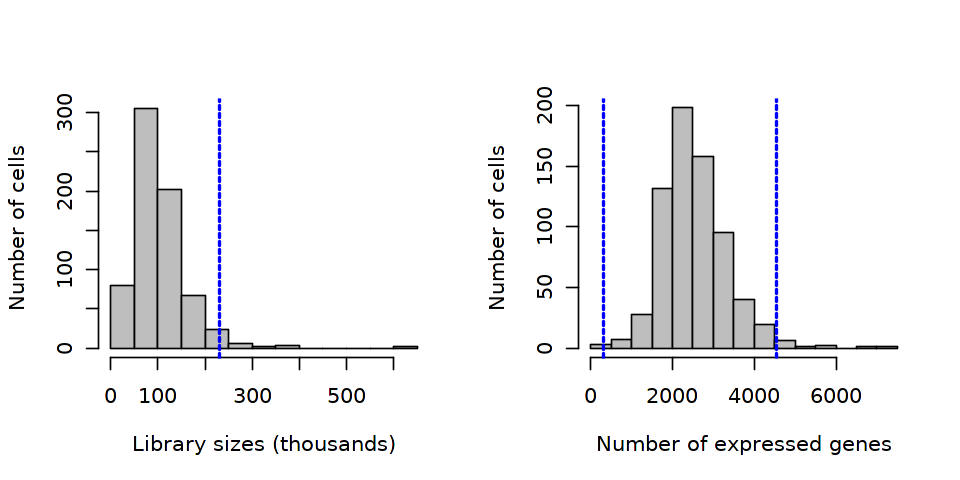

In [76]:
par(mfrow = c(1,2))
hist(sceMP$total_counts/1e3, xlab = "Library sizes (thousands)", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = -41.6222598, col = "blue", lwd = 2, lty = 2)
abline(v = 230.0582598, col = "blue", lwd = 2, lty = 2)

hist(sceMP$total_features_by_counts, xlab = "Number of expressed genes", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = 325.295, col = "blue", lwd = 2, lty = 2)
abline(v = 4550.705, col = "blue", lwd = 2, lty = 2)

options(repr.plot.width = 8, repr.plot.height = 4)

Another measure of quality is the proportion of reads mapped to genes in the mitochondrial genome. High
proportions are indicative of poor quality cells (Ilicic et al., 2016), possibly because of increased apoptosis
and/or loss of cytoplasmic RNA from lysed cells. In addition, a high proportion of mitochondrial reads could
reflect an inefficient capture of the RNA when creating the library.
By assuming most cells in the dataset are of high quality, the threshold to remove cells with too high
mitochondrial proportions can be set to remove any large outliers. For this, the median absolute deviation
method is used again.

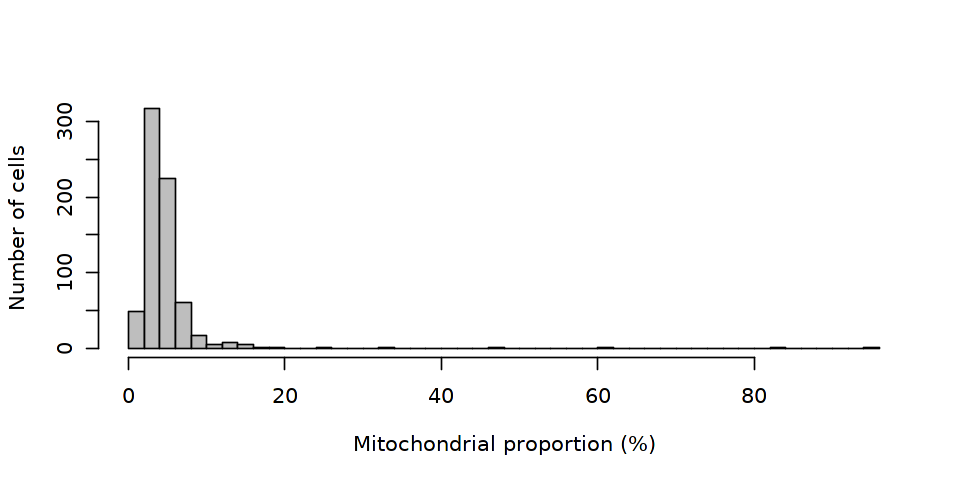

In [56]:
hist(sceMP$pct_counts_Mt, xlab = "Mitochondrial proportion (%)",
                          ylab = "Number of cells",
                          breaks = 40, main = "", col = "grey")

In [57]:
mito.drop <- isOutlier(sceMP$pct_counts_Mt, nmads = 3, type = "higher")

In [78]:
# mito.drop cutoff value
(median(sceMP$pct_counts_Mt) + 3*mad(sceMP$pct_counts_Mt))

[1] 8.771065

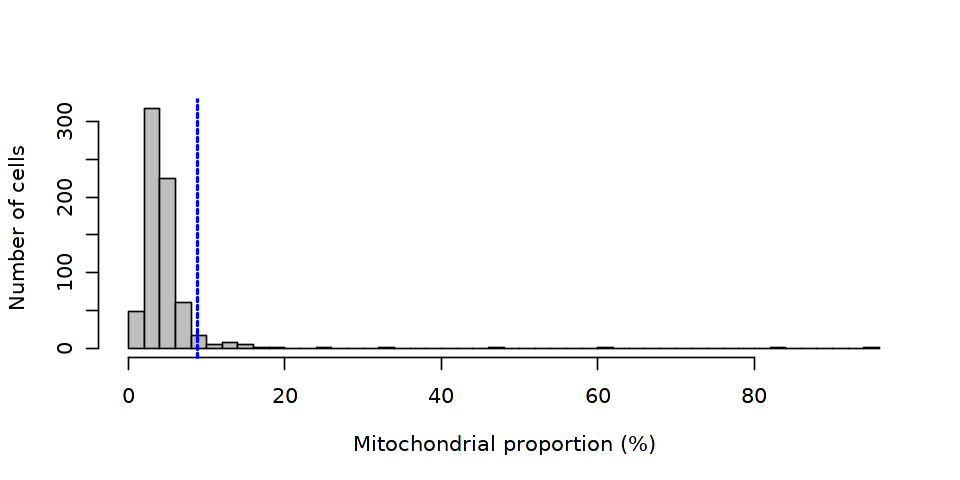

In [79]:
hist(sceMP$pct_counts_Mt, xlab = "Mitochondrial proportion (%)",
                          ylab = "Number of cells",
                          breaks = 40, main = "", col = "grey")

abline(v = 8.77106549680103, col = "blue", lwd = 2, lty = 2)

Subset by column to retain only high-quality cells that pass all filters.

In [58]:
sceMP.qc <- sceMP[,!(libsize.drop | feature.drop | mito.drop)]
data.frame(ByLibrarySize = sum(libsize.drop), ByFeature = sum(feature.drop), ByMito = sum(mito.drop),
           Remaining = ncol(sceMP.qc))

ByLibrarySize,ByFeature,ByMito,Remaining
11,13,30,656


11 cells were rejected based on the library size criterion, 13 were removed based on very low or high gene expression counts. 30 more are removed for having a higher than expected proportion of mitochondrial reads, leading to a final total of 656 cells. This very closely approximates the final number of cells in the original publication, where 656 cells were retained.

An alternative approach to perform quality control is to perfom a PCA based on the quality metrics for
each cell, e.g., the total number of reads, the total number of features and the proportion of mitochondrial
reads. Outliers on a PCA plot may be indicative of low-quality cells that have aberrant technical properties
compared to the majority of high-quality cells.

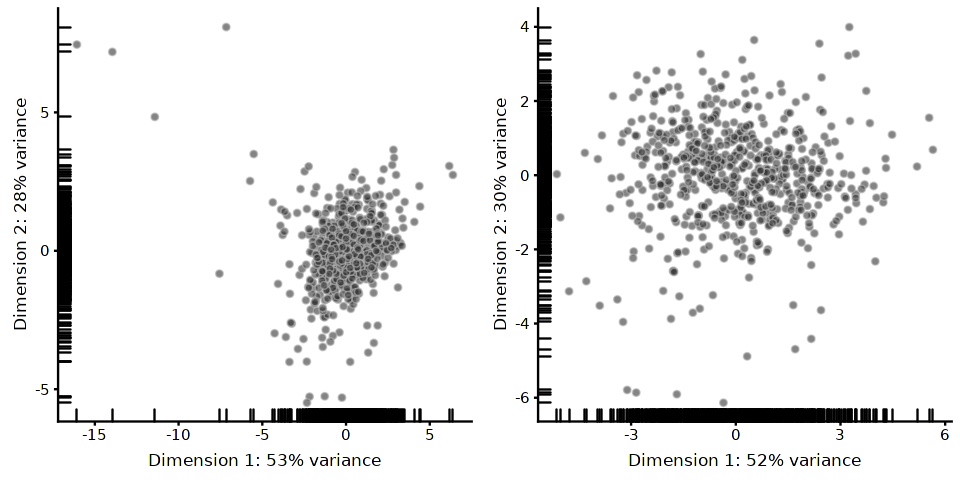

In [61]:
sceMP <- runPCA(sceMP, use_coldata = TRUE, detect_outliers = TRUE)
sceMP.qc <- runPCA(sceMP.qc, use_coldata = TRUE, detect_outliers = TRUE)

PCA.plot1 <- plotReducedDim(sceMP, use_dimred = "PCA_coldata", add_ticks = FALSE) + geom_rug()
PCA.plot2 <- plotReducedDim(sceMP.qc, use_dimred = "PCA_coldata", add_ticks = FALSE) + geom_rug()

plot_grid(PCA.plot1, PCA.plot2)

### Filtering out low-abundance genes

Low-abundance genes are problematic as zero or near-zero counts do not contain enough information for
reliable statsitical inference. Here, low-abundance genes are defined as those with an average count below a
filter threshold of 0.001 (Davie et al., 2018). Removal of these genes mitigates discreteness and reduces the
amount of computational work without major (if any) loss of information.

In [62]:
average.counts <- calculateAverage(sceMP.qc, exprs_values = "counts",
                                   use_size_factors = FALSE, subset_row = NULL)
genes.to.keep <- average.counts >= 0.001
sum(genes.to.keep)

[1] 25534

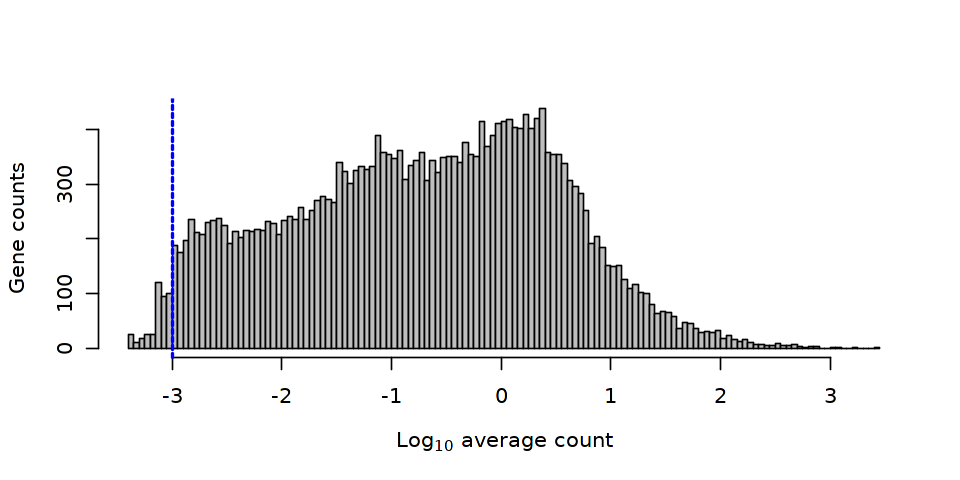

In [63]:
hist(log10(average.counts), breaks = 100, main = "", col = "grey",
     xlab = expression(Log[10]~"average count"), ylab = "Gene counts")
abline(v = log10(0.001), col = "blue", lwd = 2, lty = 2)

The mean-based filter is then applied to the data by subsetting the `SingleCellExperiment` object. This removes all rows corresponding to endogenous genes with abundances below the specified threshold.

In [80]:
sce <- sceMP.qc[genes.to.keep,]
dim(sce)

[1] 25534   656

Dimensions of the filtered and quality-controlled data are **25.534 genes and 656 cells**. In total, 754 genes and 35 cells were filtered out. 

Remove duplicate features:

In [81]:
sce <- sce[!duplicated(rownames(sce)),]
dim(sce)

[1] 25534   656

Lastly, we look at the identities of the most highly expressed genes. This should be dominated by consitutively
expressed transcripts, such as those for ribosomal or mitochondrial proteins. The presence of other classes of
genes may be of concern when not consistent with expected biology. For example, a top set void of ribosomal
proteins and/or their pseudogenes is indicative of suboptimal alignment.

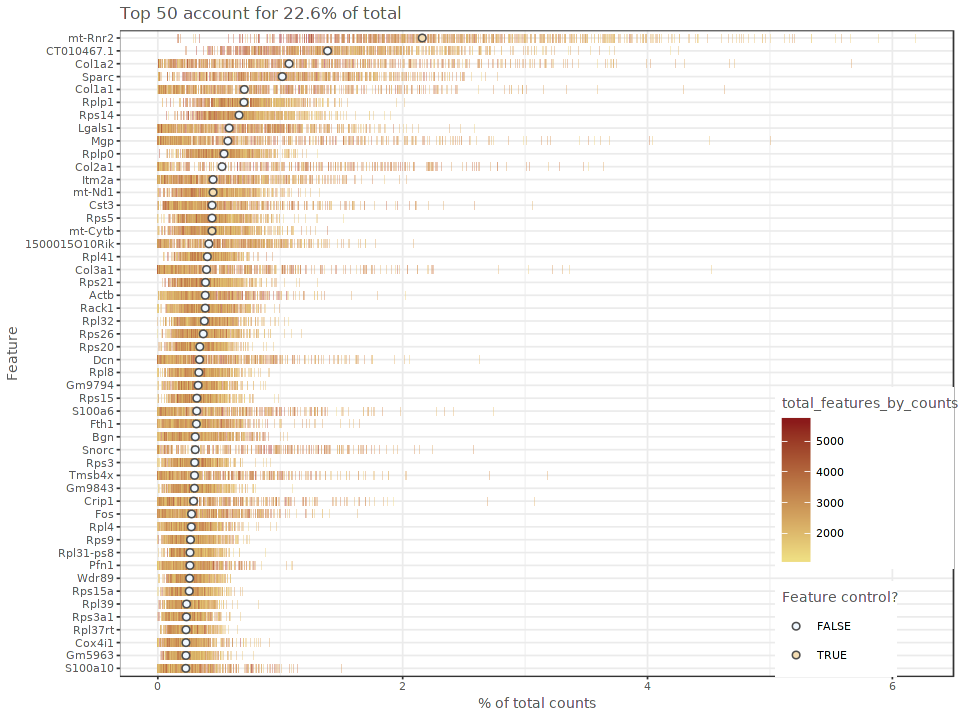

In [84]:
plotHighestExprs(sce, n = 50)
options(repr.plot.width = 8, repr.plot.height = 8)

## Finalization of the dataset

In order to be compatible with Seurat, log-transformed counts (logcounts assay) need to be added to the `SingleCellExperiment` object.

In [85]:
logcounts(sce) <- log2(counts(sce)+1)
names(sce@assays)

[1] "counts"    "logcounts"

In [86]:
saveRDS(sce, file = "Debnath.mouse.femoral.periosteum_QCfiltered.Rds")